In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

In [3]:
def softplus(x, β = 1):
    """
    Computes the softplus function of the given input x.
    
    Args:
        x (float or numpy.ndarray): The input values to compute the softplus function for.
        β (float, optional): The scaling factor for the input x. Defaults to 1.

    Returns:
        float or numpy.ndarray: The output of the softplus function, with the same shape as x.
    """
    return np.log(1+np.exp(-np.abs(x))) + np.maximum(x,0)

In [100]:
def dense(h, W, b):
    
    """
    Computes the output of a dense layer given an input h, a kernel matrix W, and bias parameters b.

    Args:
        h (numpy.ndarray): A K x h_in array of input values.
        W (numpy.ndarray): An h_in x h_out array for kernel matrix parameters.
        b (numpy.ndarray): A length h_out 1-D array for bias parameters.

    Returns:
        numpy.ndarray: A K x h_out array containing the output of the dense layer.
    """
    return  h @ W + b

In [101]:
def activation_derivative(a):
    """
    Computes the derivative of the activation function used in a neural network's hidden layer.

    The activation function used in this implementation is a\
    numerically stable version of the ReLU functiongiven by:\
    1 / (1 + exp(-a)) for a >= 0, and exp(a) / (1 + exp(a)) for a < 0.

    Args:
        a (numpy.ndarray): A K x 200 array of hidden layer pre-activations.

    Returns:
        numpy.ndarray: A K x 200 array of diagonal elements\
        containing the derivative of the activation function with respect
        to the input a.
    """
    
    derivative = np.where(a >= 0, 
                1 / (1 + np.exp(-a)), 
                np.exp(a) / (1 + np.exp(a)))

    
    return  derivative # dlog(1+exp(x)) = exp(x)/(1+exp(x))

In [98]:
def one_hot_encode(y):
    """
    Encodes a 1-D array of labels into one-hot vectors.

    Arguments:
    y: 1-D numpy array of shape (N,), where N is the number of samples.
       The values represent the class labels.

    Returns:
    A numpy array of shape (N, num_classes), where num_classes is the number of unique labels.
    Each row represents the one-hot encoding of the corresponding label in y.
    """
    
    num_classes = np.max(y) + 1  # number of unique classes
    y_batch_prob = np.zeros((y.shape[0], num_classes))

    for i in range(y.shape[0]):
        y_batch_prob[i, y[i]] = 1.

    return y_batch_prob

In [16]:
def neural (x, W0, b0, W1, b1, β=1):
    """
    Implements a 1-layer neural network with the given weights and biases,\
    and applies a softmax function to the output.

    Args:
        x (numpy.ndarray): A K x N array of input data.
        W0 (numpy.ndarray): An h_in x h_out array of weights for the first hidden layer.
        b0 (numpy.ndarray): A length h_out 1-D array of biases for the first hidden layer.
        W1 (numpy.ndarray): An h_out x h_out array of weights for the second hidden layer.
        b1 (numpy.ndarray): A length h_out 1-D array of biases for the second hidden layer.
        β (float, optional): The β value to use for the softplus activation function. Defaults to 1.

    Returns:
        numpy.ndarray: A K x 10 output array containing the softmax activation of the neural network's output layer.
    """
    
    # Compute the activations and outputs for the input layer and each hidden layer
    a1 = dense(x, W0, b0)
    h1 = softplus(a1, β)
    
    # Compute the pre-softmax output of the neural network
    a2 = dense(h1, W1, b1)
    
    # Apply the softmax function to the output of the neural network
    return softmax(a2)

In [17]:
def KL_loss(x_batch, y_batch, W0, b0, W1, b1):
    """
    Computes the Kullback-Leibler divergence loss between predicted and actual labels.

    Arguments:
    x_batch: 2-D numpy array of shape (K, D), where K is the batch size and D is the number of features.
             The input data for the batch.
    y_batch: 1-D numpy array of shape (K,), where K is the batch size.
             The actual class labels for the input data.
    W0: 2-D numpy array of shape (D, h), where h is the number of hidden units in the first layer.
    b0: 1-D numpy array of shape (h,), where h is the number of hidden units in the first layer.
        The bias parameters for the first layer.
    W1: 2-D numpy array of shape (h, h), where h is the number of hidden units in each hidden layer.
    b1: 1-D numpy array of shape (h,), where h is the number of hidden units in each hidden layer.
        The bias parameters for each hidden layer.
    W2: 2-D numpy array of shape (h, h), where h is the number of hidden units in each hidden layer.
    b2: 1-D numpy array of shape (h,), where h is the number of hidden units in each hidden layer.
        The bias parameters for each hidden layer.
    W3: 2-D numpy array of shape (h, num_classes), where num_classes is the number of unique labels.
    b3: 1-D numpy array of shape (num_classes,), where num_classes is the number of unique labels.
        The bias parameters for the output layer.

    Returns:
    The mean Kullback-Leibler divergence loss over the batch.
    """
    y_out = mlp(x_batch, W0, b0, W1, b1)
    
    y_batch = one_hot_encode(y_batch)

    #modification to KL divergence to ensure numerical stability
    KL_divergence = y_batch[np.where(y_batch != 0)]*np.log(y_batch[np.where(y_batch != 0)]/y_out[np.where(y_batch != 0)])
    
    return np.mean(KL_divergence)


In [21]:
def backpropagate(x_batch, y_batch, W0, b0, W1,b1, β = 1):
    """
    Computes the gradients of the weights and biases in the neural network\
    for a given batch of inputs and labels.
    
    Args:
        x_batch (np.ndarray): K x D array of inputs
        y_batch (np.ndarray): K x 1 array of outputs
        W0 (np.ndarray): D x 200 array of weights for the first hidden layer
        b0 (np.ndarray): 1 x 200 array of biases for the first hidden layer
        W1 (np.ndarray): 200 x 200 array of weights for the second hidden layer
        b1 (np.ndarray): 1 x 200 array of biases for the second hidden layer
        W2 (np.ndarray): 200 x 200 array of weights for the third hidden layer
        b2 (np.ndarray): 1 x 200 array of biases for the third hidden layer
        W3 (np.ndarray): 200 x 10 array of weights for the output layer
        b3 (np.ndarray): 1 x 10 array of biases for the output layer
        β (float): Scaling factor for the softplus activation function. Default is 1.

    Returns:
        dW0 (np.ndarray): D x 200 array of weight gradients for the first hidden layer
        db0 (np.ndarray): 1 x 200 array of bias gradients for the first hidden layer
        dW1 (np.ndarray): 200 x 200 array of weight gradients for the second hidden layer
        db1 (np.ndarray): 1 x 200 array of bias gradients for the second hidden layer
        dW2 (np.ndarray): 200 x 200 array of weight gradients for the third hidden layer
        db2 (np.ndarray): 1 x 200 array of bias gradients for the third hidden layer
        dW3 (np.ndarray): 200 x 10 array of weight gradients for the output layer
        db3 (np.ndarray): 1 x 10 array of bias gradients for the output layer
    """
    
    #propagate forward x_batch through network:
        
    a1 = dense(x_batch, W0, b0)
    h1 = softplus(a1, β)
    

    #pre-softmax output

    a2 = dense(h1, W1, b1)

    #Backward pass
    
    #one-hot encoding of labels
    y_batch_prob = one_hot_encode(y_batch)
        
    
    delta2 = softmax(a2) - y_batch_prob  
    delta1 =  activation_derivative(a1)*(delta2@W1.T) 
    
    # gradients

    dW1 = (1/x_batch.shape[0])*(delta2.T@h1).T
    db1 = np.mean(delta2, axis = 0)
    
    
    dW0 = (1/x_batch.shape[0])*(delta1.T@x_batch).T
    db0 = np.mean(delta1, axis = 0)

    return dW0, db0, dW1,db1

In [33]:
# Run the SGD algorithm
def train_mlp(X_train, y_train, X_test, y_test, P = 200, learning_rate = 0.01, batch_size = 128, epochs = 40, scores = False):
    """
    The train_mlp function trains a multi-layer perceptron (MLP) on a given training dataset and returns the trained weights and biases. The function also computes the KL divergence loss and accuracy scores for both the training and test datasets over the training epochs.

    Args:

        X_train: 2D numpy array of shape (n_samples, n_features) containing the training data features.
        y_train: 1D numpy array of shape (n_samples,) containing the training data labels.
        X_test: 2D numpy array of shape (n_samples, n_features) containing the test data features.
        y_test: 1D numpy array of shape (n_samples,) containing the test data labels.
        learning_rate: float, optional learning rate for the optimizer, default is 0.01.
        batch_size: int, optional mini-batch size for the stochastic gradient descent, default is 128.
        epochs: int, optional number of training epochs, default is 40.
        scores: boolean, optional flag to return loss and accuracy scores, default is False.

    Returns:

        If scores is False, returns the final trained weights and biases for each layer and test loss during training:
            W0: 2D numpy array of shape (n_features, 200) representing the weights for the first hidden layer.
            b0: 2D numpy array of shape (1, 200) representing the biases for the first hidden layer.
            W1: 2D numpy array of shape (200, 200) representing the weights for the second hidden layer.
            b1: 2D numpy array of shape (1, 200) representing the biases for the second hidden layer.
            losses_test: numpy array of shape (epochs,) containing test losses during training.
            
        If scores is True, returns the final trained weights and biases for each layer along\
        with the loss and accuracy scores for both the training and test datasets:
            losses_train: 1D numpy array of shape (epochs,) \
            containing the KL divergence loss for each epoch on the training dataset.
            losses_test: 1D numpy array of shape (epochs,)\
            containing the KL divergence loss for each epoch on the test dataset.
            accuracy_train: 1D numpy array of shape (epochs,)\
            containing the mean accuracy score for each epoch on the training dataset.
            accuracy_test: 1D numpy array of shape (epochs,)\
            containing the mean accuracy score for each epoch on the test dataset.
    """
    
    #initialise weights
    
    N,d = X_train.shape
    
    var0 = 6. / (d+P)
    W0 =  np.random.uniform(-np.sqrt(var0), np.sqrt(var0), (d, P) )
    b0 = np.zeros(P).reshape(1,-1)
    
    var1 = 6. / (P+10)
    W1 =  np.random.uniform(-np.sqrt(var1), np.sqrt(var1), (P, 10) )
    b1 = np.zeros(10).reshape(1,-1)
    
    losses_train = []
    losses_test = []
    accuracy_train = []
    accuracy_test = []
    
    for epoch in trange(epochs):
        #shuffle data
        p = np.random.permutation(N)
        X_train = X_train[p]
        y_train = y_train[p]
        
        # iterate over minibatches
        indices = np.arange(N)

        np.random.shuffle(indices)
        
        for start_idx in range(0, N - batch_size +1, batch_size):
            
            batch_idx = indices[start_idx:start_idx + batch_size]
            
            #sampling minibatch
            x_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
            
            dW0, db0, dW1,db1 =\
            backpropagate(x_batch, y_batch, W0, b0, W1,b1)
            
            W0 -= learning_rate * dW0 
            b0 -= learning_rate * db0 
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            
            
        #compute KL divergence loss per epoch
        losses_train.append(np.mean(KL_loss(X_train, y_train, W0, b0, W1,b1)))
        losses_test.append(np.mean(KL_loss(X_test, y_test, W0, b0, W1,b1)))

        #compute mlp predictions
        
        y_pred_train = np.argmax(mlp(X_train, W0, b0, W1,b1), axis = 1)
        
        y_pred_test = np.argmax(mlp(X_test, W0, b0, W1,b1), axis = 1)
        
        #compute model mean accuracy scores
        #print(f'Training set accuracy: {len(y_train[y_pred_train == y_train])/len(y_train)}\n')
        #print(f'Training set loss: {loss_train}\n')
        accuracy_train.append(len(y_train[y_pred_train == y_train])/len(y_train))
        accuracy_test.append(len(y_test[y_pred_test == y_test])/len(y_test))
        
    if scores == True:
        return losses_train, losses_test, accuracy_train, accuracy_test
        
    return W0, b0, W1,b1, losses_test

In [23]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [24]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data['label']))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data['label'])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)

In [102]:
def params_func(P):
    learning_rate = 2.15443469e-02
    W0, b0, W1, b1, losses_test = train_mlp(train_data_std, y_train, test_data_std,  y_test, P = P, learning_rate =\
          learning_rate, batch_size = 128, epochs = 30, scores = False)
    params = np.ndarray.flatten(W1)
    '''np.concatenate((np.ndarray.flatten(W0),np.ndarray.flatten(W1), np.ndarray.flatten(b0),\
                             np.ndarray.flatten(b1)))'''
    
    return params, losses_test

In [106]:
params_2, losses_2 = params_func(100)
params_3, losses_2 = params_func(1000)
params_4, losses_2 = params_func(int(1e4))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

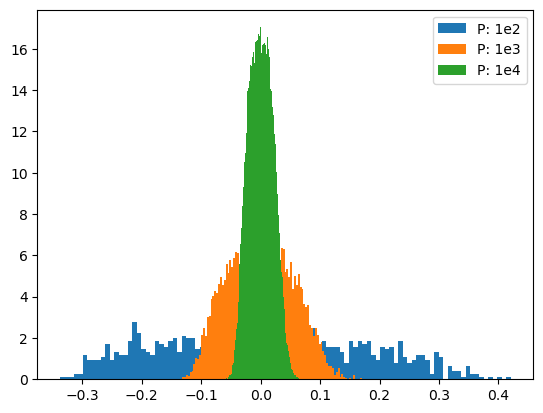

In [108]:
plt.hist(params_2, label = 'P: 1e2', bins = 100, density = True)
plt.hist(params_3, label = 'P: 1e3', bins = 100, density = True)
plt.hist(params_4, label = 'P: 1e4', bins = 100, density = True)

plt.legend()